## Image Captioning
- Generating Captions for Images

### Steps 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
from pickle import load, dump
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions
    

In [3]:
captions  = readTextFile("../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
print(captions)
#captions = captions[0:100]
captions = captions.split('\n')[:-1]

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b

In [4]:
print(len(captions))

40460


In [5]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
# Dictionary to Map each Image with the list of captions it has

In [7]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [8]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

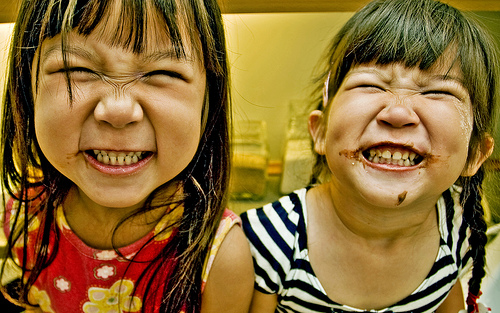

In [9]:
IMG_PATH = "../input/flickr8k/Flickr_Data/Flickr_Data/Images/"
import matplotlib.pyplot as plt
from pathlib import Path
image_path = Path("../input/flickr8k/Flickr_Data/Flickr_Data/Images")
from keras.preprocessing import image
image.load_img("../input/flickr8k/Flickr_Data/Flickr_Data/Images/2490179961_e842fda5eb.jpg")
#plt.imshow(img)

### Data Cleaning


In [10]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [11]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [12]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [13]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [14]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 

In [15]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [16]:
print(type(descriptions))

<class 'dict'>


In [17]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [18]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 373837


In [19]:
# Filter Words from the Vocab according to certain threshold frequncy

In [20]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [21]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [22]:
print(len(total_words))

1845


### Prepare Train/Test Data

In [23]:
train_file_data = readTextFile("../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [24]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [25]:
print(len(train))
print(len(test))

train[:5]

6000
1000


['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [26]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [27]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [28]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [29]:
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [30]:
model_new = Model(model.input,model.layers[-2].output)

In [31]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(299,299))
    #plt.imshow(img)
    #Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
   # x = np.reshape(x, x.shape[1])
    return x

In [32]:
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [33]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    #print(image.load_img(img))
    feature_vector = feature_vector.reshape((-1,))
    print(feature_vector.shape)
    return feature_vector

In [34]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

(2048,)


array([0.12277626, 0.3329497 , 0.7527176 , ..., 0.21939701, 0.30216452,
       0.40283167], dtype=float32)

In [35]:
# start = time()
# encoding_train = {}
# #image_id -->feature_vector extracted from Resnet Image

# for ix,img_id in enumerate(train):
#     img_path = IMG_PATH+"/"+img_id+".jpg"
#     encoding_train[img_id] = encode_image(img_path)
    
#     if ix%100==0:
#         print("Encoding in Progress Time step %d "%ix)
        
# end_t = time()
# print("Total Time Taken :",end_t-start)

(2048,)
Encoding in Progress Time step 0 
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
Encoding in Progress Time step 100 
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2

In [36]:
!mkdir saved

In [37]:
import pickle

In [38]:
# # Store everything to the disk 
# with open("encoded_train_features_inception.pkl","wb") as f:
#     pickle.dump(encoding_train,f)

In [39]:
# start = time()
# encoding_test = {}
# #image_id -->feature_vector extracted from Resnet Image

# for ix,img_id in enumerate(test):
#     img_path = IMG_PATH+"/"+img_id+".jpg"
#     encoding_test[img_id] = encode_image(img_path)
    
#     if ix%100==0:
#         print("Test Encoding in Progress Time step %d "%ix)
        
# end_t = time()
# print("Total Time Taken(test) :",end_t-start)

(2048,)
Test Encoding in Progress Time step 0 
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
Test Encoding in Progress Time step 100 
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)


In [40]:
# with open("encoded_test_features_inception.pkl","wb") as f:
#     pickle.dump(encoding_test,f)

In [41]:
encoding_train = {} 
encoded_test = {}
with open ("../input/encoded-images/encoded_train_features_inception.pkl","rb") as w2i:
    encoding_train = pickle.load(w2i)

with open ("../input/encoded-images/encoded_test_features_inception.pkl","rb") as w2i:
    encoding_test = pickle.load(w2i)

### Data pre-processing for Captions

In [42]:
# Vocab
len(total_words)

1845

In [43]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [44]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [45]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [46]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


### Data Loader (Generator)

In [47]:
from keras.utils import to_categorical

def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## Word Embeddings 

In [48]:
f = open("../input/glove6b50dtxt/glove.6B.50d.txt",encoding='utf8')

In [49]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [50]:
f.close()

In [51]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [52]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [53]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [54]:
#embedding_matrix[1847]

#### Model Architecture

In [55]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [56]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [57]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [58]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [59]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [60]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [61]:
epochs = 15
batch_size_is_cool = 5
steps = len(train_descriptions)//batch_size_is_cool 


In [62]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size_is_cool)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('inception_model_'+str(i)+'.h5')

In [63]:
train()

Epoch 1/1
1200/1200 [==============================] - 408s 340ms/step - loss: 4.3580
Epoch 1/1
1200/1200 [==============================] - 405s 337ms/step - loss: 3.6278
Epoch 1/1
1200/1200 [==============================] - 405s 337ms/step - loss: 3.3668
Epoch 1/1
1200/1200 [==============================] - 404s 337ms/step - loss: 3.2000
Epoch 1/1
1200/1200 [==============================] - 404s 337ms/step - loss: 3.0814
Epoch 1/1
1200/1200 [==============================] - 403s 335ms/step - loss: 2.9862
Epoch 1/1
1200/1200 [==============================] - 403s 336ms/step - loss: 2.9120
Epoch 1/1
1200/1200 [==============================] - 407s 339ms/step - loss: 2.8479
Epoch 1/1
1200/1200 [==============================] - 409s 341ms/step - loss: 2.7965
Epoch 1/1
1200/1200 [==============================] - 412s 344ms/step - loss: 2.7486
Epoch 1/1
1200/1200 [==============================] - 414s 345ms/step - loss: 2.7097
Epoch 1/1
1200/1200 [==============================] -

In [ ]:
import History

In [78]:
history = History()
model.fit_generator( someparameters,  callbacks=[history])
print(history.history)

NameError: name 'History' is not defined

In [77]:
import matplotlib.pyplot as plt

acc = hist.history['acc']

NameError: name 'hist' is not defined

In [65]:
#model = load_model('../kaggle/working/inception_model_9.h5')

In [66]:
#print(encoding_train['2513260012_03d33305cf'])

## Predictions

In [67]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

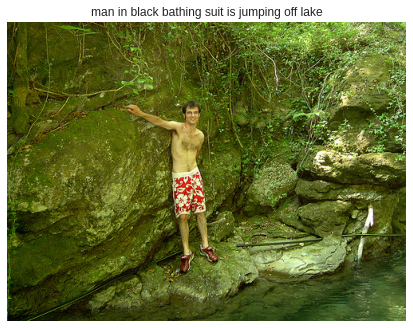

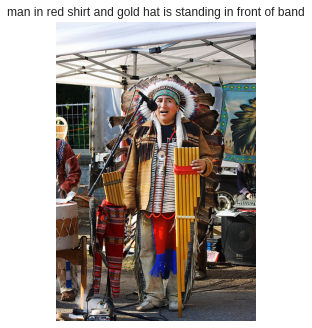

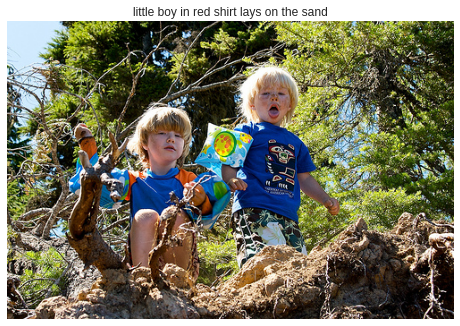

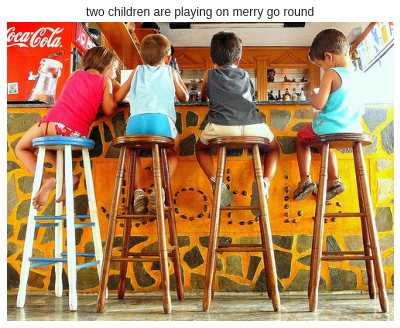

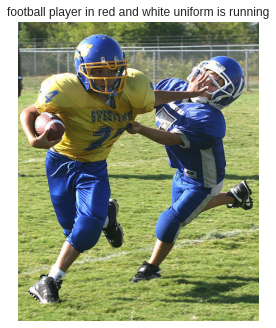

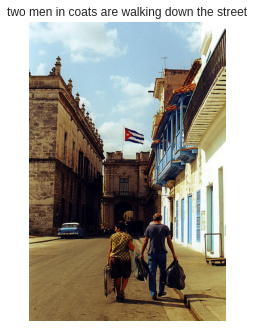

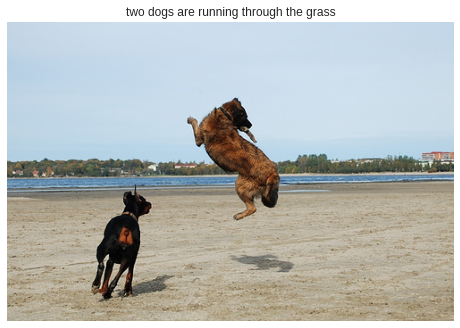

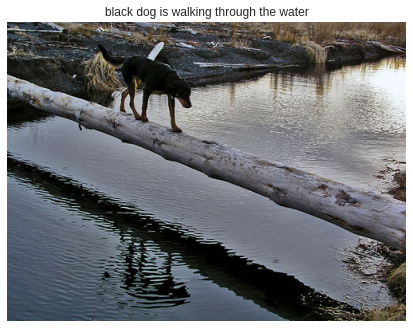

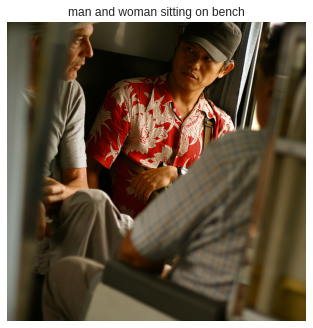

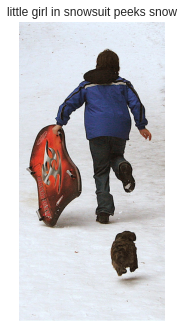

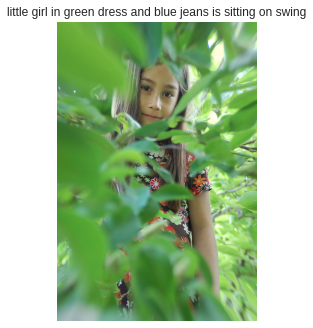

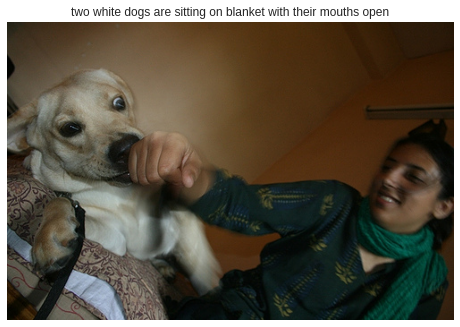

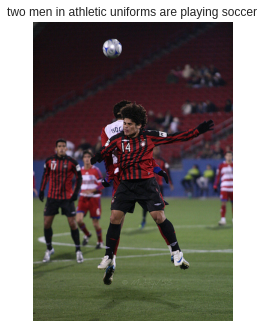

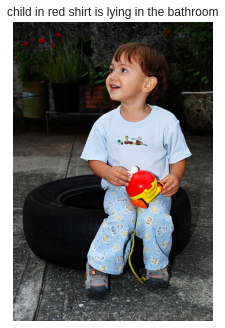

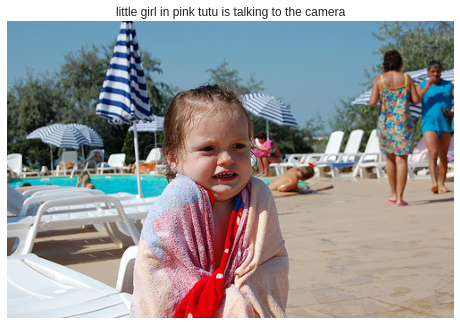

In [68]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("../input/flickr8k/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [ ]:
#encoding_test["3385593926_d3e9c21170"].shape

In [ ]:
#calculation of bleu score

In [69]:
img_name = all_img_names[idx]
print(img_name)

2762301555_48a0d0aa24


In [75]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_train.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_train[img_name].reshape((1,2048))
    
    i = plt.imread("../input/flickr8k/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    actual_caption = train_descriptions[img_name]
    actual_caption = (actual_caption[0])
    final_caption = actual_caption.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
   
    
    caption = caption.split()
    final_caption = final_caption.split()
    
    print(caption)
    print(final_caption)
    print("/n")
    import nltk
    print(nltk.translate.bleu_score.sentence_bleu(caption,final_caption))
    

['man', 'wearing', 'straw', 'hat', 'smokes', 'cigarette']
['man', 'wearing', 'black', 'hat', 'is', 'walking', 'through', 'busy', 'city', 'street']
/n
0
['man', 'in', 'black', 'shirt', 'and', 'black', 'hat', 'holding', 'newspaper']
['construction', 'worker', 'drills', 'hole', 'into', 'the', 'ground']
/n
0
['little', 'girl', 'in', 'blue', 'bathing', 'suit', 'jumps', 'into', 'swimming', 'pool']
['boy', 'jumps', 'into', 'the', 'pool']
/n
0
['brown', 'dog', 'running', 'through', 'the', 'snow']
['brown', 'dog', 'running', 'through', 'the', 'woods']
/n
0
['little', 'girl', 'in', 'pink', 'bathing', 'suit', 'walks', 'on', 'the', 'beach']
['small', 'child', 'running', 'on', 'the', 'beach']
/n
0
['two', 'people', 'are', 'in', 'the', 'water']
['children', 'playing', 'in', 'pool']
/n
0
['woman', 'in', 'red', 'shirt', 'and', 'blue', 'shorts', 'is', 'laughing']
['blonde', 'woman', 'with', 'her', 'hair', 'up', 'is', 'taking', 'off', 'white', 'sweatshirt']
/n
0
['child', 'in', 'striped', 'shirt', 'is',